In [8]:
import skimage as ski
import skimage.io as io
from matplotlib import pyplot as plt

image_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/keyence/stitched_FF_images/lmx1b_20230830/E01_t0000_ch01_stitch.tif"
mask_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/segmentation/unet_emb_v4_0050_predictions/lmx1b_20230830/E01_t0000_ch01_stitch.tif"

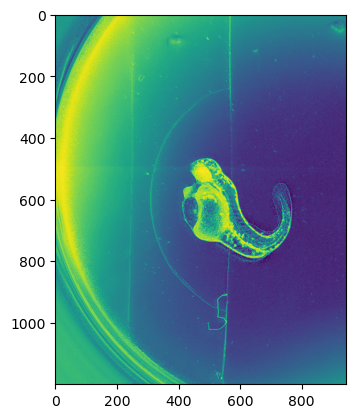

In [9]:
im = io.imread(image_path)
mask = io.imread(mask_path)

plt.imshow(im)
plt.show()

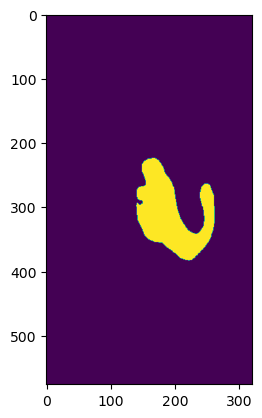

In [10]:
from skimage.measure import label
mask2 = label(mask)
plt.imshow(mask2==2)
plt.show()

mask2 = mask2==2

### Try some simple morphological operations

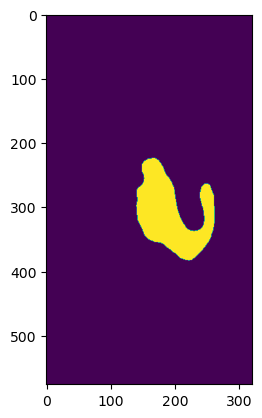

In [17]:
from skimage.morphology import disk, binary_closing

radius = 15
i_disk = disk(radius)

mask_closed = binary_closing(mask2, i_disk)

plt.imshow(mask_closed)
plt.show()

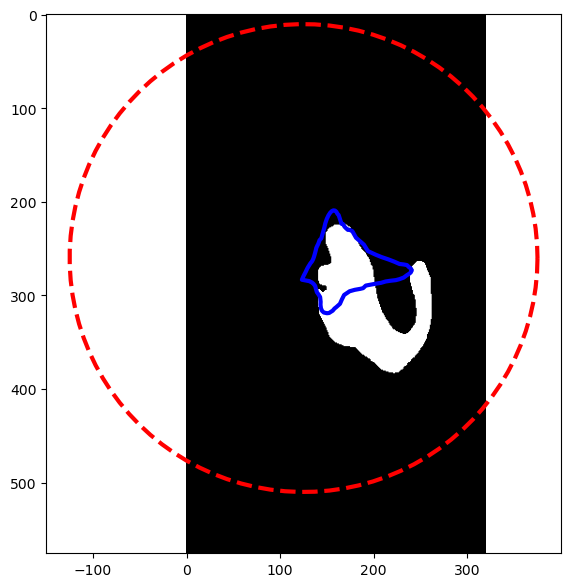

In [4]:
import numpy as np
from skimage.draw import circle_perimeter
from skimage.filters import gaussian
from skimage.segmentation import active_contour

s = np.linspace(0, 2*np.pi, 100)
init = 250 * np.array([np.sin(s), np.cos(s)]).T + np.asarray([260, 125])
snake = active_contour(mask2, init, alpha=3, beta=0, w_edge=10, w_line=10, coordinates='rc')

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mask2, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
plt.show()

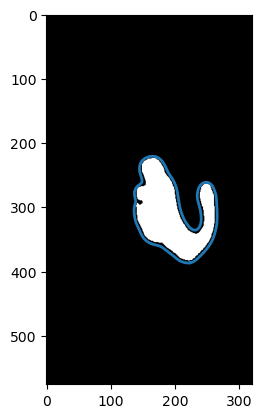

In [5]:
from skimage import measure

mask2_sm = ski.filters.gaussian(mask2, sigma=5)
contours = measure.find_contours(mask2_sm, 0.2)

fig, ax = plt.subplots()
ax.imshow(mask2, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
plt.show()

/var/folders/m7/tpjttxb92tl8b4c9svgvgby00000gn/T/ipykernel_35460/2237824140.py:3: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  im_dist = scipy.ndimage.morphology.distance_transform_edt(~mask2)


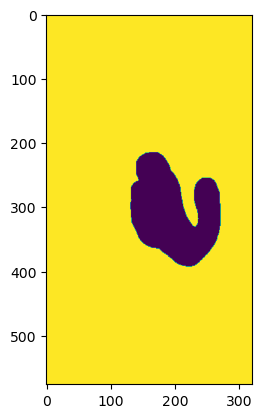

In [6]:
import scipy

im_dist = scipy.ndimage.morphology.distance_transform_edt(~mask2)

plt.imshow(im_dist>=10)
plt.show()

In [7]:
import cv2

contours, hierarchy = cv2.findContours(mask2.astype(np.uint8), cv2.RETR_LIST, 10)


fig, ax = plt.subplots()
ax.imshow(mask2, cmap=plt.cm.gray)

for contour in contours:
    contour = np.squeeze(contour)
    perimeter = cv2.arcLength(contour, True)
    approximatedShape = cv2.approxPolyDP(contour, 0.005 * perimeter, True)
    ashp = np.squeeze(approximatedShape)
    ax.plot(contour[:, 0], contour[:, 1], linewidth=2)
    ax.plot(ashp[:, 0], ashp[:, 1], linewidth=2)
    
plt.show()

error: OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/contours.cpp:204: error: (-211:One of the arguments' values is out of range)  in function 'cvStartFindContours_Impl'


In [ ]:
import numpy
from scipy.interpolate import splprep, splev



smoothened = []
for contour in contours:
    x,y = contour.T
    # Convert from numpy arrays to normal arrays
    x = x.tolist()[0]
    y = y.tolist()[0]
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
    tck, u = splprep([x,y], u=None, s=1.0, per=1)
    # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
    u_new = numpy.linspace(u.min(), u.max(), 25)
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
    x_new, y_new = splev(u_new, tck, der=0)
    # Convert it back to numpy format for opencv to be able to display it
    res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
    smoothened.append(numpy.asarray(res_array, dtype=numpy.int32))

# Overlay the smoothed contours on the original image
cv2.drawContours(mask2.astype(np.uint8), smoothened, -1, (255,255,255), 2)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(mask2, cmap=plt.cm.gray)

smoothened = np.squeeze(smoothened)
np.squeeze(approximatedShape)
ax.plot(smoothened[:, 0], smoothened[:, 1], linewidth=2)
    
plt.show()

In [ ]:
import alphashape

xi, yi = np.meshgrid(range(mask2.shape[0]), range(mask2.shape[1]), indexing="ij")

x_coords = xi[mask2]
y_coords = yi[mask2]

coord_array = np.concatenate((y_coords[:, np.newaxis], x_coords[:, np.newaxis]), axis=1)
shape = alphashape.alphashape(coord_array, 0.4)

In [ ]:
shape